## LSTM Iterator

##### Imports

In [1]:
import LSTM_model_creator as lstm_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import data_utils
# Add a config.py file to the local directory with two variables: HTTP Headers (dict) and FRED API Key (str)

2024-01-15 18:22:03.534905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 18:22:03.534933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 18:22:03.535922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 18:22:03.540785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 18:22:04.180896: W tensorflow/compiler/tf2

##### Pull S&P Data

In [2]:
sp_df = data_utils.get_sp_ticker_list()
sp_df

/home/henrywh/Desktop/PORTFOLIO PROJECTS/LSTM Iterator/data_utils.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  s_p_df = pd.read_html(str(tables[0]))[0]


,#,Company,Symbol,Price,Chg,% Chg,Weight
0,1,Microsoft Corp,MSFT,388.47,3.84,(1.00%),7.08
1,2,Apple Inc.,AAPL,185.92,0.33,(0.18%),6.78
2,3,Amazon.com Inc,AMZN,154.62,-0.56,(-0.36%),3.48
3,4,Nvidia Corp,NVDA,547.10,-1.12,(-0.20%),3.34
4,5,Alphabet Inc. Class A,GOOGL,142.65,0.57,(0.40%),2.10
...,...,...,...,...,...,...,...
498,499,Ralph Lauren Corporation,RL,138.02,-4.51,(-3.16%),0.01
499,500,V.F. Corporation,VFC,16.21,-0.75,(-4.42%),0.01
500,501,"Mohawk Industries, Inc.",MHK,101.85,-2.61,(-2.50%),0.01
501,502,Fox Corporation Class B,FOX,28.75,0.13,(0.45%),0.01


##### Ticker List

In [3]:
ticker_weights = sp_df[['Symbol','Weight']]
ticker_weights['Weight'] = ticker_weights['Weight']/100

/tmp/ipykernel_172907/1190938767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_weights['Weight'] = ticker_weights['Weight']/100


##### Iterator Method

In [4]:
def get_lstm_pred(ticker, macro_features, start_date, end_date, train_prop, val_prop, look_back, epochs):

    stock_dict = data_utils.get_stock_prices(ticker, start_date, end_date)
    stock_df = stock_dict[ticker[0]]
    pr_vol_df = pd.DataFrame({'Volume':stock_df['Volume'], 'Price':stock_df['Adj Close']})
    data_df = pd.concat([macro_features, pr_vol_df], axis=1).dropna()
    dates, data_sc = lstm_utils.mm_scale(data_df)
    dates_train, data_train, dates_val, data_val, dates_test, data_test = lstm_utils.tvt_split(dates, data_sc, train_prop=train_prop, val_prop=val_prop)
    x_train, y_train = lstm_utils.arr_to_xy(data_train, look_back=look_back)
    x_val, y_val = lstm_utils.arr_to_xy(data_val, look_back=look_back)
    x_test, y_test = lstm_utils.arr_to_xy(data_test, look_back=look_back)
    train_pred, val_pred, test_pred = lstm_utils.lstm_model_pred(x_train, y_train, x_val, y_val, x_test, epochs)

    backtest_df = lstm_utils.simple_backtest(look_back, dates_test, y_test, test_pred)
    lstm_utils.pred_vis(look_back, dates_train, dates_val, dates_test, y_train, y_val, y_test, 
                  train_pred, val_pred, test_pred, show_train=False, show_val=False, show_test=True)
    
    return backtest_df

##### Parameters

In [5]:
start_date = '2010-07-01'
end_date = '2023-03-30'
train_prop = 0.8    # Training roportion
val_prop = 0.1     # Validation proportion
look_back = 20      # Days to look back 
epochs = 30         # Epochs for training
num_stocks = 20     # Number of Stocks to Iterate through (chooses 'num_stocks' highest weighted in S&P)

##### Other Macro Features

In [6]:
fred = data_utils.init_fred()
macro = data_utils.get_fred_data(fred, {'VIXCLS': 'VIX', 'DGS3MO': '3 Mo Yield'}, start_date, end_date)

In [7]:
macro

,VIX,3 Mo Yield
2010-07-01,32.86,0.17
2010-07-02,30.12,0.17
2010-07-05,NaN,NaN
2010-07-06,29.65,0.17
2010-07-07,26.84,0.16
...,...,...
2023-03-24,21.74,4.74
2023-03-27,20.60,4.91
2023-03-28,19.97,4.80
2023-03-29,19.12,4.80


##### Iteration Through Tickers

MSFT


[*********************100%%**********************]  1 of 1 completed
2024-01-15 18:22:06.936455: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 18:22:06.936721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 18:22:06.969822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

Epoch 1/30


2024-01-15 18:22:08.824556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-15 18:22:09.070185: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f666f9c7fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 18:22:09.070227: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-15 18:22:09.070243: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-15 18:22:09.078060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705360929.135458  173004 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 2s 7ms/step - loss: 0.0019 - mae: 0.0207 - val_loss: 2.5560e-04 - val_mae: 0.0124
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 3.7238e-05 - mae: 0.0035 - val_loss: 3.6288e-04 - val_mae: 0.0155
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 4.1188e-05 - mae: 0.0038 - val_loss: 2.3001e-04 - val_mae: 0.0117
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 4.2314e-05 - mae: 0.0041 - val_loss: 2.2392e-04 - val_mae: 0.0115
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 4.0212e-05 - mae: 0.0040 - val_loss: 2.7622e-04 - val_mae: 0.0131
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 4.8834e-05 - mae: 0.0046 - val_loss: 5.6425e-04 - val_mae: 0.0198
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 4.2295e-05 - mae: 0.0043 - val_loss: 2.2238e-04 - val_mae: 0.0115
Epoch 8/30
79/79 [==============================]

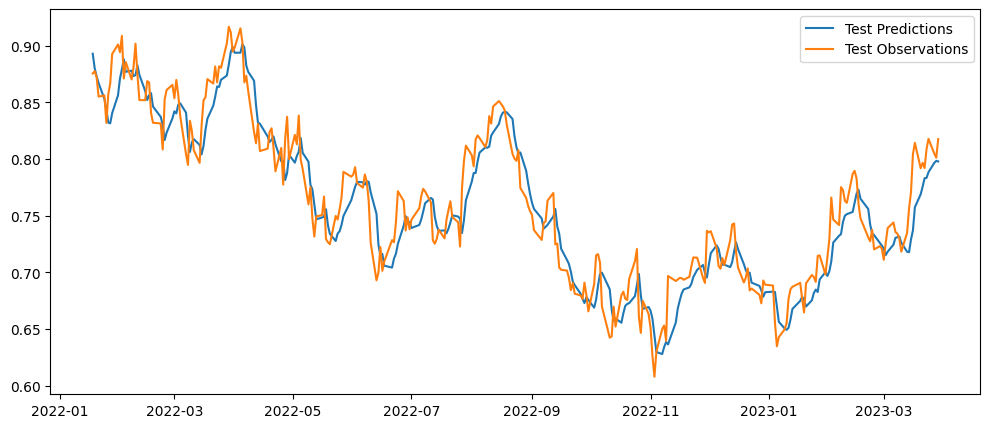

MSFT: Completed 1/20 iterations
AAPL


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0177 - val_loss: 6.9639e-04 - val_mae: 0.0219
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 5.7658e-05 - mae: 0.0049 - val_loss: 3.9293e-04 - val_mae: 0.0159
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 7.4396e-05 - mae: 0.0057 - val_loss: 0.0035 - val_mae: 0.0558
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 7.1113e-05 - mae: 0.0056 - val_loss: 3.2721e-04 - val_mae: 0.0141
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 6.4520e-05 - mae: 0.0054 - val_loss: 0.0026 - val_mae: 0.0479
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 8.3208e-05 - mae: 0.0060 - val_loss: 3.2238e-04 - val_mae: 0.0139
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 1.2001e-04 - mae: 0.0078 - val_loss: 7.5577e-04 - val_mae: 0.0235
Epoch 8/30
79/79 [==============================] - 0s 3m

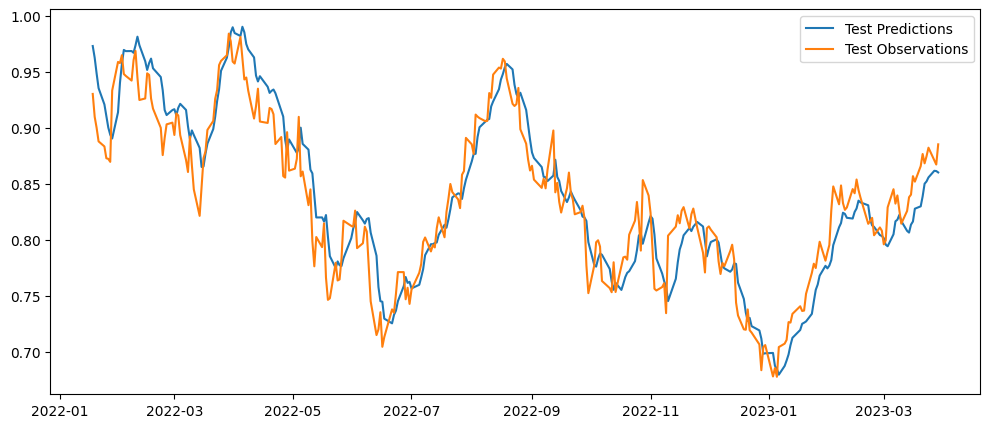

AAPL: Completed 2/20 iterations
AMZN


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0021 - mae: 0.0243 - val_loss: 4.6196e-04 - val_mae: 0.0167
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 9.0900e-05 - mae: 0.0058 - val_loss: 4.2290e-04 - val_mae: 0.0161
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 1.0315e-04 - mae: 0.0063 - val_loss: 5.7784e-04 - val_mae: 0.0196
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 1.5996e-04 - mae: 0.0080 - val_loss: 5.7320e-04 - val_mae: 0.0195
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 1.3280e-04 - mae: 0.0078 - val_loss: 5.1715e-04 - val_mae: 0.0184
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 1.1939e-04 - mae: 0.0071 - val_loss: 4.3812e-04 - val_mae: 0.0168
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 9.5155e-05 - mae: 0.0065 - val_loss: 4.8701e-04 - val_mae: 0.0178
Epoch 8/30
79/79 [==============================]

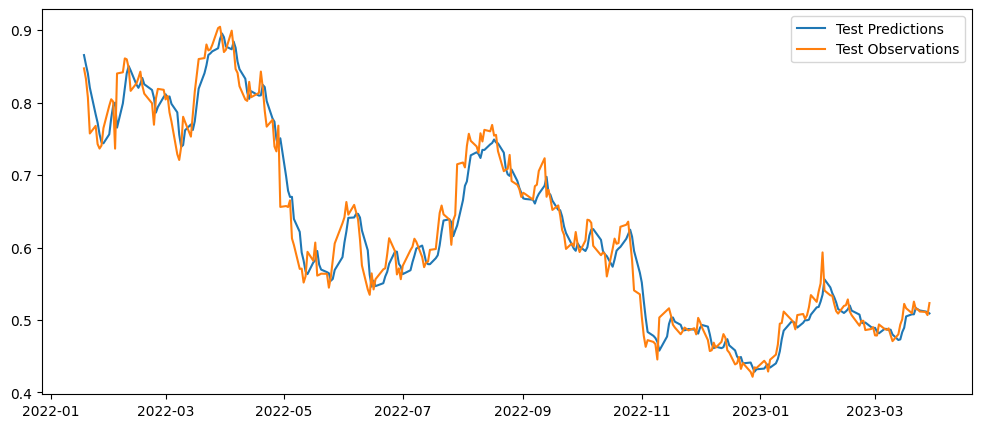

AMZN: Completed 3/20 iterations
NVDA


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 6.3072e-04 - mae: 0.0132 - val_loss: 9.3559e-04 - val_mae: 0.0239
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 2.5164e-05 - mae: 0.0031 - val_loss: 7.3575e-04 - val_mae: 0.0187
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 2.4216e-05 - mae: 0.0031 - val_loss: 8.6478e-04 - val_mae: 0.0228
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 3.1516e-05 - mae: 0.0038 - val_loss: 7.2312e-04 - val_mae: 0.0200
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 3.0714e-05 - mae: 0.0037 - val_loss: 6.8110e-04 - val_mae: 0.0181
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 3.6725e-05 - mae: 0.0040 - val_loss: 5.8201e-04 - val_mae: 0.0169
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 3.0771e-05 - mae: 0.0038 - val_loss: 6.3423e-04 - val_mae: 0.0180
Epoch 8/30
79/79 [===========================

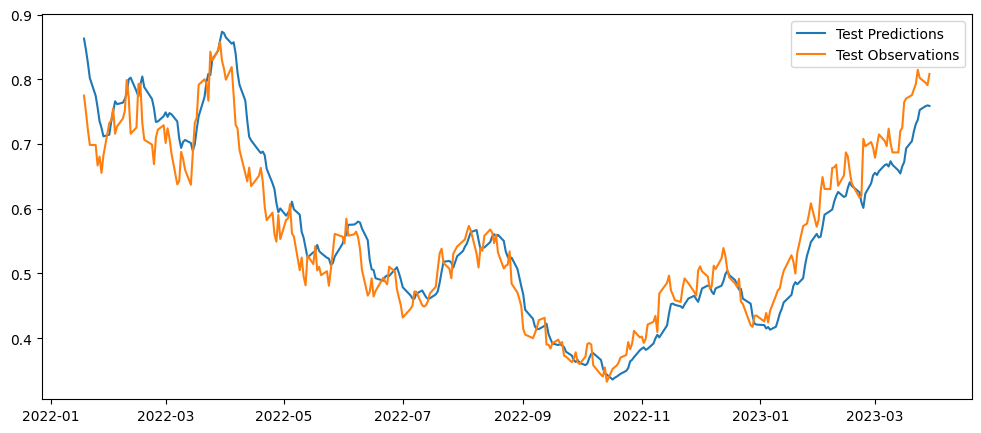

NVDA: Completed 4/20 iterations
GOOGL


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0013 - mae: 0.0190 - val_loss: 4.5292e-04 - val_mae: 0.0170
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 5.5388e-05 - mae: 0.0050 - val_loss: 2.9882e-04 - val_mae: 0.0131
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 5.1165e-05 - mae: 0.0049 - val_loss: 3.7569e-04 - val_mae: 0.0152
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 5.9707e-05 - mae: 0.0056 - val_loss: 2.8161e-04 - val_mae: 0.0125
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 6.1150e-05 - mae: 0.0056 - val_loss: 2.8597e-04 - val_mae: 0.0128
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 5.7915e-05 - mae: 0.0054 - val_loss: 2.7017e-04 - val_mae: 0.0126
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 5.6751e-05 - mae: 0.0054 - val_loss: 3.0062e-04 - val_mae: 0.0135
Epoch 8/30
79/79 [==============================]

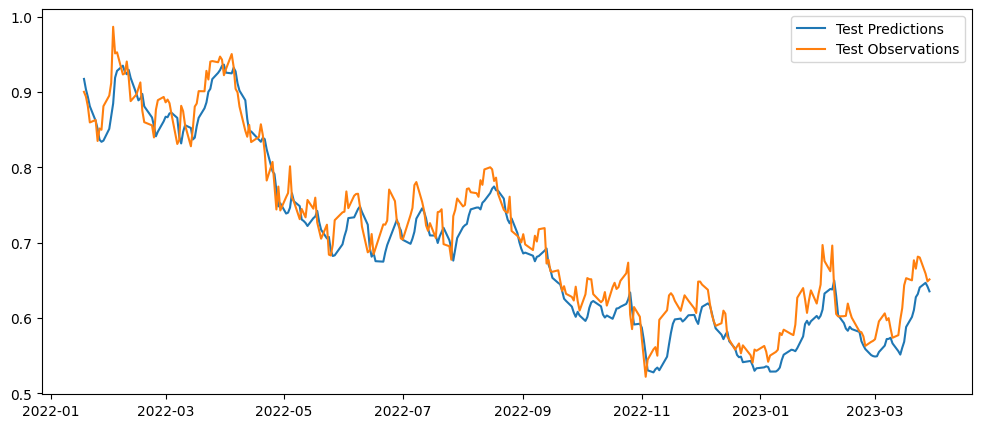

GOOGL: Completed 5/20 iterations
META


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


68/68 [==============================] - 2s 7ms/step - loss: 0.0039 - mae: 0.0366 - val_loss: 0.0012 - val_mae: 0.0240
Epoch 2/30
68/68 [==============================] - 0s 3ms/step - loss: 1.8437e-04 - mae: 0.0091 - val_loss: 0.0017 - val_mae: 0.0296
Epoch 3/30
68/68 [==============================] - 0s 4ms/step - loss: 1.6637e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0238
Epoch 4/30
68/68 [==============================] - 0s 3ms/step - loss: 1.4840e-04 - mae: 0.0080 - val_loss: 9.9972e-04 - val_mae: 0.0212
Epoch 5/30
68/68 [==============================] - 0s 3ms/step - loss: 1.4545e-04 - mae: 0.0079 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 6/30
68/68 [==============================] - 0s 3ms/step - loss: 1.6050e-04 - mae: 0.0085 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 7/30
68/68 [==============================] - 0s 3ms/step - loss: 1.7086e-04 - mae: 0.0091 - val_loss: 9.0133e-04 - val_mae: 0.0203
Epoch 8/30
68/68 [==============================] - 0s 4ms/step - los

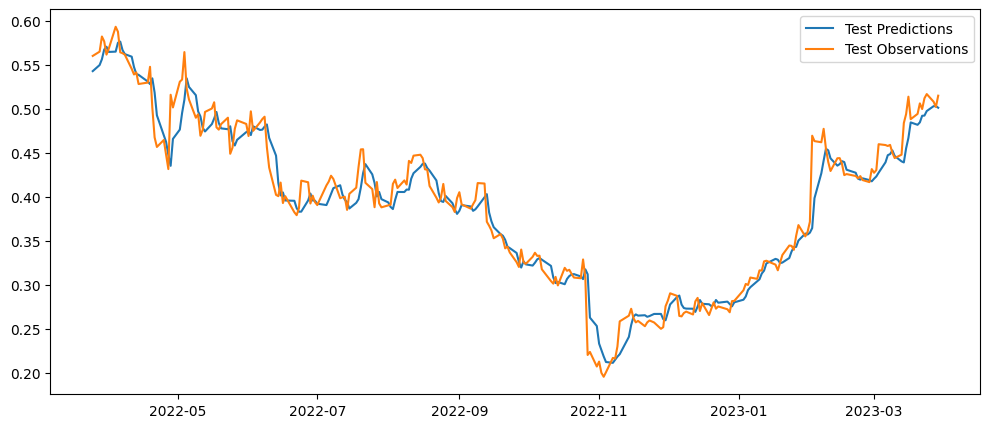

META: Completed 6/20 iterations
GOOG


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0017 - mae: 0.0229 - val_loss: 0.0011 - val_mae: 0.0278
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 6.6636e-05 - mae: 0.0056 - val_loss: 2.8211e-04 - val_mae: 0.0128
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 4.4812e-05 - mae: 0.0046 - val_loss: 2.8558e-04 - val_mae: 0.0130
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 4.3834e-05 - mae: 0.0045 - val_loss: 3.5991e-04 - val_mae: 0.0146
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 4.8826e-05 - mae: 0.0049 - val_loss: 2.9901e-04 - val_mae: 0.0132
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 5.1492e-05 - mae: 0.0050 - val_loss: 2.8952e-04 - val_mae: 0.0130
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 5.9127e-05 - mae: 0.0054 - val_loss: 3.6500e-04 - val_mae: 0.0149
Epoch 8/30
79/79 [==============================] - 0

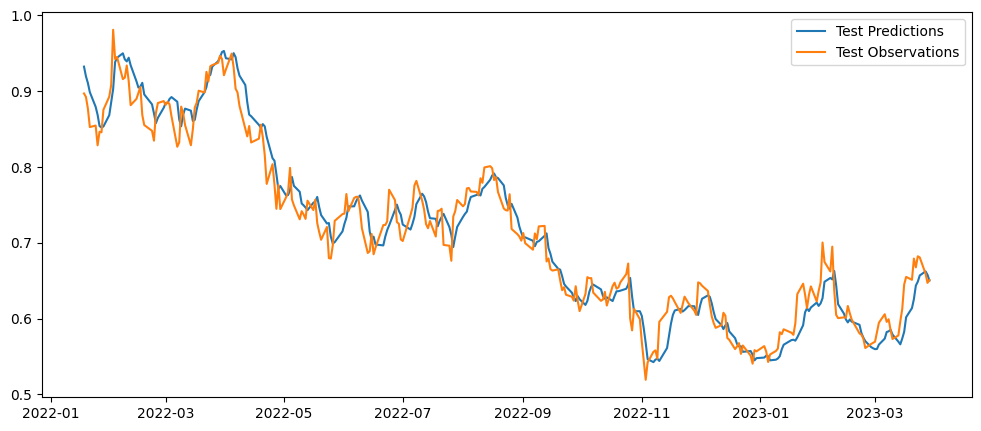

GOOG: Completed 7/20 iterations
BRK-B


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0036 - mae: 0.0320 - val_loss: 0.0011 - val_mae: 0.0301
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 9.7745e-05 - mae: 0.0069 - val_loss: 5.6089e-04 - val_mae: 0.0200
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 7.8505e-05 - mae: 0.0061 - val_loss: 4.3055e-04 - val_mae: 0.0172
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 8.5322e-05 - mae: 0.0066 - val_loss: 2.1046e-04 - val_mae: 0.0112
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 8.2322e-05 - mae: 0.0063 - val_loss: 5.6627e-04 - val_mae: 0.0206
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 8.8527e-05 - mae: 0.0068 - val_loss: 7.1376e-04 - val_mae: 0.0237
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 8.9550e-05 - mae: 0.0068 - val_loss: 1.4241e-04 - val_mae: 0.0092
Epoch 8/30
79/79 [==============================] - 0

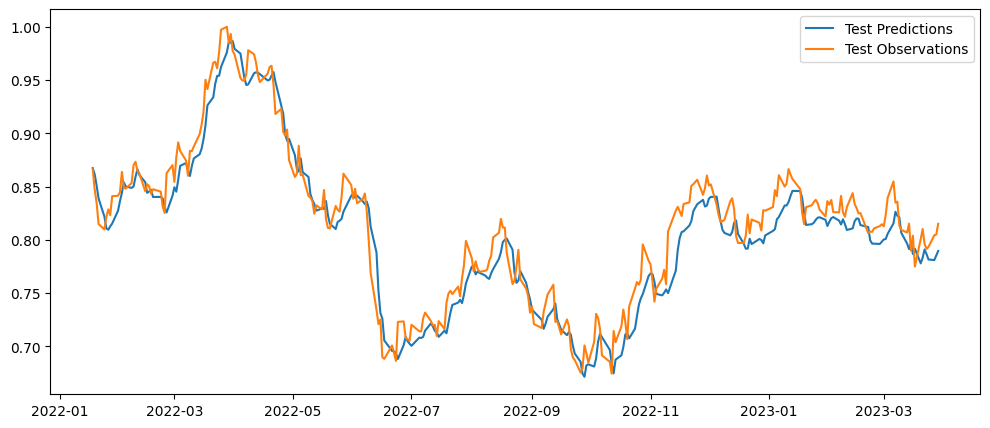

BRK-B: Completed 8/20 iterations
TSLA


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 4.2859e-04 - mae: 0.0108 - val_loss: 0.0044 - val_mae: 0.0578
Epoch 2/30
79/79 [==============================] - 0s 4ms/step - loss: 3.7731e-05 - mae: 0.0036 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 3.8690e-05 - mae: 0.0039 - val_loss: 0.0014 - val_mae: 0.0266
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 3.8937e-05 - mae: 0.0037 - val_loss: 0.0014 - val_mae: 0.0285
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 5.1930e-05 - mae: 0.0046 - val_loss: 0.0012 - val_mae: 0.0250
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 4.6032e-05 - mae: 0.0046 - val_loss: 0.0017 - val_mae: 0.0320
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 6.0853e-05 - mae: 0.0052 - val_loss: 0.0016 - val_mae: 0.0320
Epoch 8/30
79/79 [==============================] - 0s 3ms/step - loss: 3

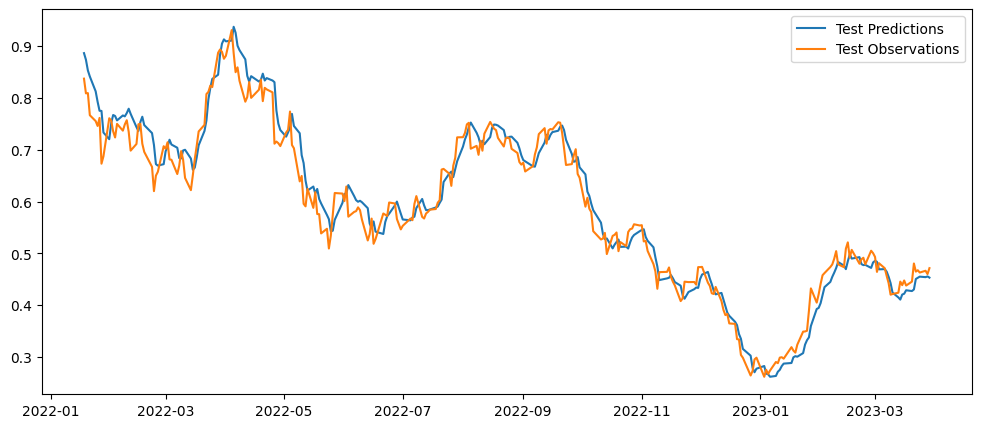

TSLA: Completed 9/20 iterations
LLY


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0016 - mae: 0.0190 - val_loss: 4.0439e-04 - val_mae: 0.0147
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 3.2822e-05 - mae: 0.0039 - val_loss: 4.3573e-04 - val_mae: 0.0155
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 3.0288e-05 - mae: 0.0036 - val_loss: 4.1198e-04 - val_mae: 0.0150
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 3.6304e-05 - mae: 0.0041 - val_loss: 3.5396e-04 - val_mae: 0.0142
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 4.6901e-05 - mae: 0.0049 - val_loss: 8.2705e-04 - val_mae: 0.0239
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 4.6168e-05 - mae: 0.0046 - val_loss: 3.2006e-04 - val_mae: 0.0128
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 3.6629e-05 - mae: 0.0043 - val_loss: 0.0010 - val_mae: 0.0273
Epoch 8/30
79/79 [==============================] - 0

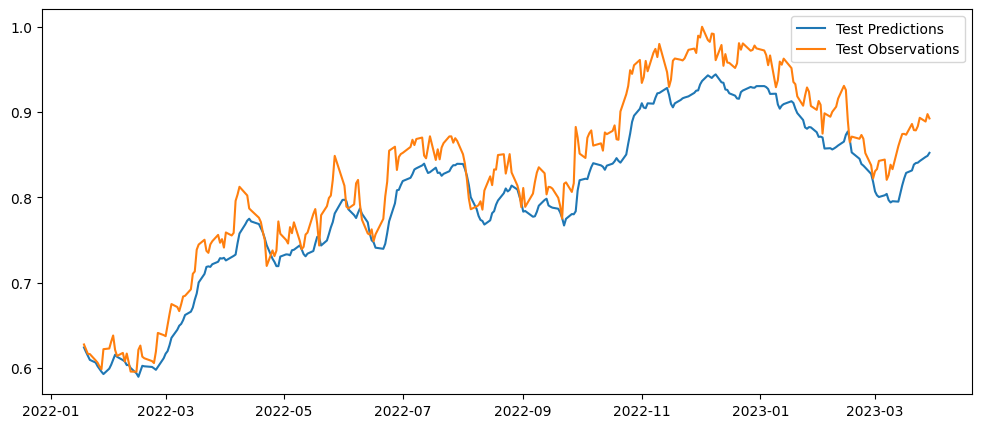

LLY: Completed 10/20 iterations
UNH


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 5ms/step - loss: 0.0033 - mae: 0.0289 - val_loss: 7.9947e-04 - val_mae: 0.0242
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 6.7709e-05 - mae: 0.0050 - val_loss: 4.5432e-04 - val_mae: 0.0170
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 6.8521e-05 - mae: 0.0053 - val_loss: 2.1989e-04 - val_mae: 0.0113
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 6.7702e-05 - mae: 0.0055 - val_loss: 2.0869e-04 - val_mae: 0.0113
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 5.9569e-05 - mae: 0.0050 - val_loss: 2.1299e-04 - val_mae: 0.0111
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 7.0841e-05 - mae: 0.0055 - val_loss: 2.0518e-04 - val_mae: 0.0109
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 6.5615e-05 - mae: 0.0052 - val_loss: 5.3182e-04 - val_mae: 0.0190
Epoch 8/30
79/79 [==============================]

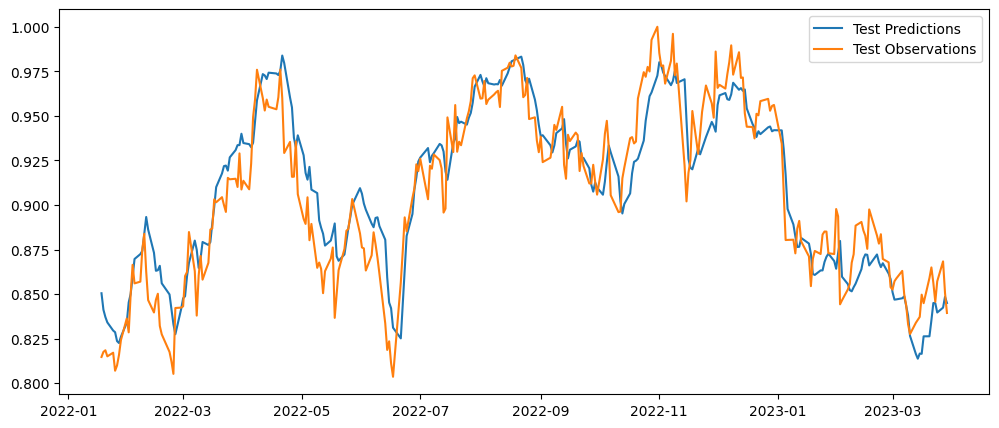

UNH: Completed 11/20 iterations
JPM


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0033 - mae: 0.0300 - val_loss: 0.0013 - val_mae: 0.0312
Epoch 2/30
79/79 [==============================] - 0s 4ms/step - loss: 1.3183e-04 - mae: 0.0077 - val_loss: 5.8192e-04 - val_mae: 0.0190
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 1.2413e-04 - mae: 0.0075 - val_loss: 4.1866e-04 - val_mae: 0.0158
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 1.2511e-04 - mae: 0.0075 - val_loss: 5.5244e-04 - val_mae: 0.0187
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 1.2912e-04 - mae: 0.0078 - val_loss: 8.8081e-04 - val_mae: 0.0247
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 1.3408e-04 - mae: 0.0080 - val_loss: 3.6377e-04 - val_mae: 0.0146
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 1.3924e-04 - mae: 0.0081 - val_loss: 4.7705e-04 - val_mae: 0.0168
Epoch 8/30
79/79 [==============================] - 0

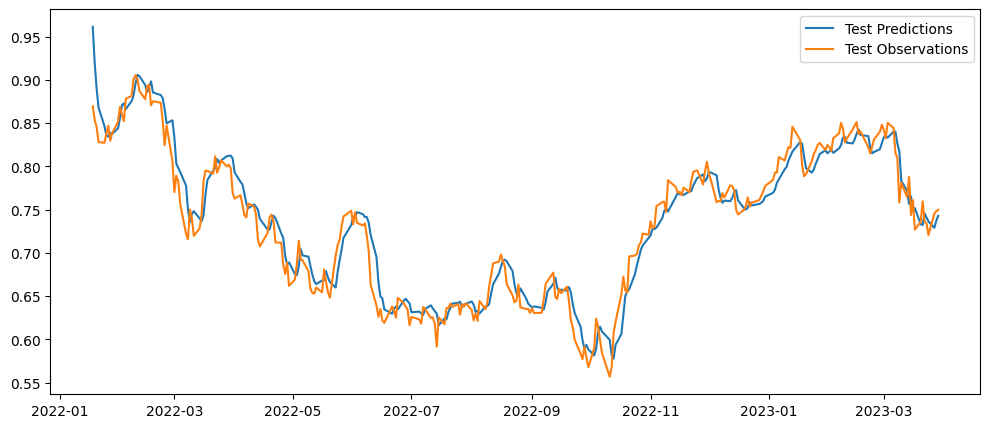

JPM: Completed 12/20 iterations
AVGO


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0019 - mae: 0.0222 - val_loss: 2.7362e-04 - val_mae: 0.0127
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 6.4847e-05 - mae: 0.0051 - val_loss: 2.4057e-04 - val_mae: 0.0114
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 5.7330e-05 - mae: 0.0049 - val_loss: 2.3104e-04 - val_mae: 0.0113
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 5.8510e-05 - mae: 0.0051 - val_loss: 4.8560e-04 - val_mae: 0.0182
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 6.3918e-05 - mae: 0.0053 - val_loss: 3.1206e-04 - val_mae: 0.0136
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 6.2837e-05 - mae: 0.0054 - val_loss: 2.1569e-04 - val_mae: 0.0109
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 6.0862e-05 - mae: 0.0055 - val_loss: 2.9089e-04 - val_mae: 0.0130
Epoch 8/30
79/79 [==============================]

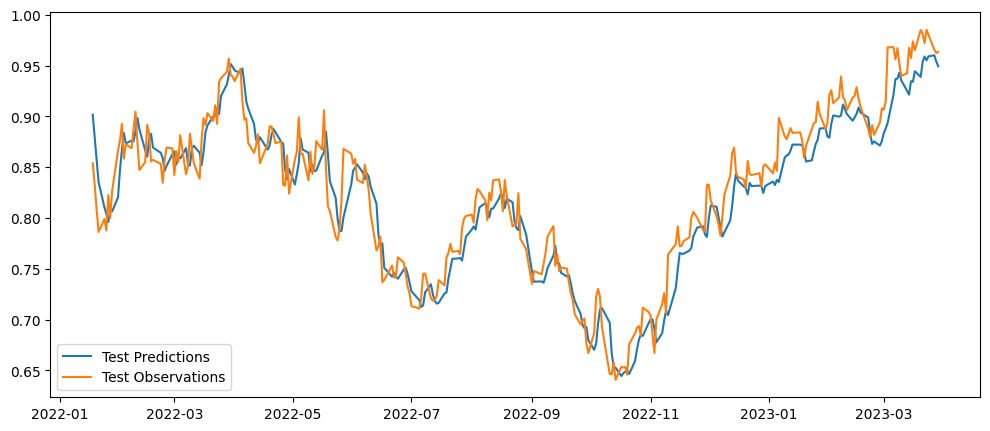

[*********************100%%**********************]  1 of 1 completed

AVGO: Completed 13/20 iterations
V
Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0042 - mae: 0.0329 - val_loss: 4.4429e-04 - val_mae: 0.0163
Epoch 2/30
79/79 [==============================] - 0s 4ms/step - loss: 9.8168e-05 - mae: 0.0061 - val_loss: 6.5165e-04 - val_mae: 0.0199
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 8.4580e-05 - mae: 0.0056 - val_loss: 3.9656e-04 - val_mae: 0.0149
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 7.9674e-05 - mae: 0.0054 - val_loss: 7.7998e-04 - val_mae: 0.0225
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 8.1031e-05 - mae: 0.0056 - val_loss: 3.8830e-04 - val_mae: 0.0148
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 8.6602e-05 - mae: 0.0058 - val_loss: 4.6896e-04 - val_mae: 0.0162
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 9.0996e-05 - mae: 0.0061 - val_loss: 8.2293e-04 - val_mae: 0.0245
Epoch 8/30
79/79 [==============================]

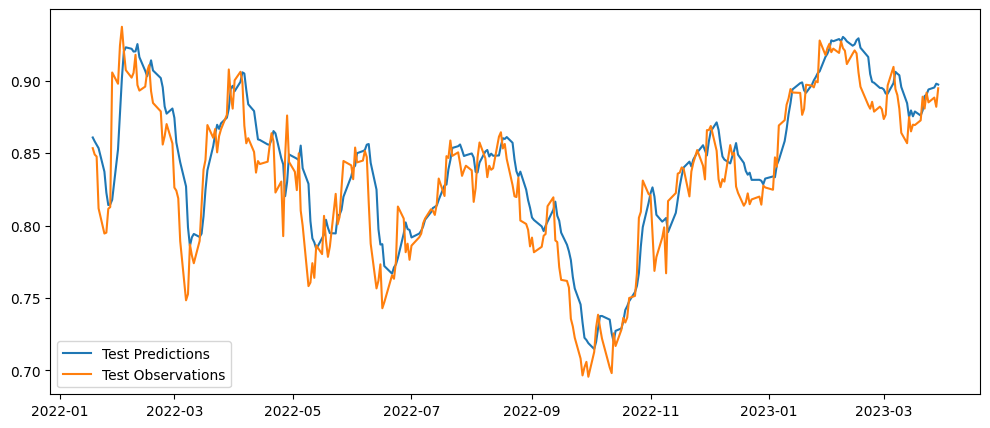

V: Completed 14/20 iterations
XOM


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 7ms/step - loss: 0.0044 - mae: 0.0373 - val_loss: 4.5885e-04 - val_mae: 0.0173
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 1.6069e-04 - mae: 0.0096 - val_loss: 5.3652e-04 - val_mae: 0.0183
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 1.3131e-04 - mae: 0.0087 - val_loss: 4.1640e-04 - val_mae: 0.0160
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1717e-04 - mae: 0.0081 - val_loss: 2.5828e-04 - val_mae: 0.0125
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 1.1436e-04 - mae: 0.0080 - val_loss: 2.5845e-04 - val_mae: 0.0124
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 1.1644e-04 - mae: 0.0081 - val_loss: 2.1880e-04 - val_mae: 0.0118
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 1.3097e-04 - mae: 0.0086 - val_loss: 2.3885e-04 - val_mae: 0.0121
Epoch 8/30
79/79 [==============================]

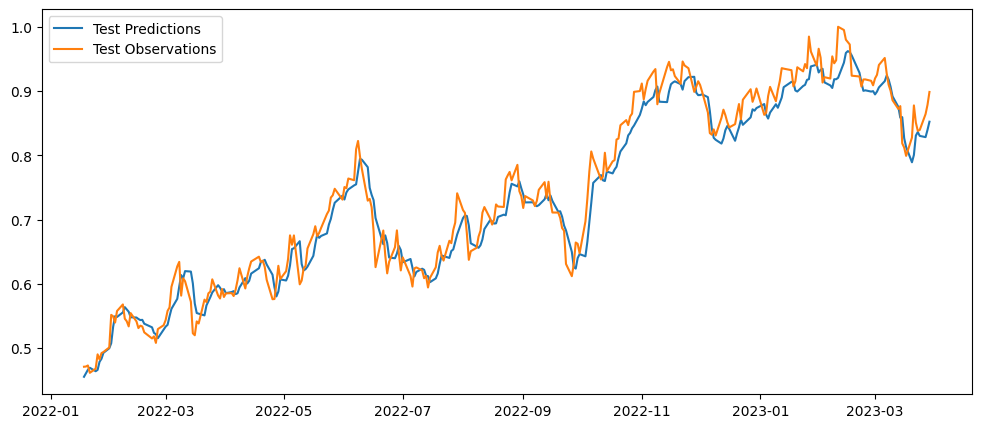

XOM: Completed 15/20 iterations
JNJ


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0048 - mae: 0.0357 - val_loss: 3.1035e-04 - val_mae: 0.0140
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 1.2881e-04 - mae: 0.0077 - val_loss: 2.7318e-04 - val_mae: 0.0132
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 1.2455e-04 - mae: 0.0075 - val_loss: 2.3362e-04 - val_mae: 0.0121
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 1.0990e-04 - mae: 0.0071 - val_loss: 2.1181e-04 - val_mae: 0.0115
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1610e-04 - mae: 0.0074 - val_loss: 2.6190e-04 - val_mae: 0.0129
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1941e-04 - mae: 0.0075 - val_loss: 5.5296e-04 - val_mae: 0.0201
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 1.3566e-04 - mae: 0.0082 - val_loss: 2.4802e-04 - val_mae: 0.0126
Epoch 8/30
79/79 [==============================]

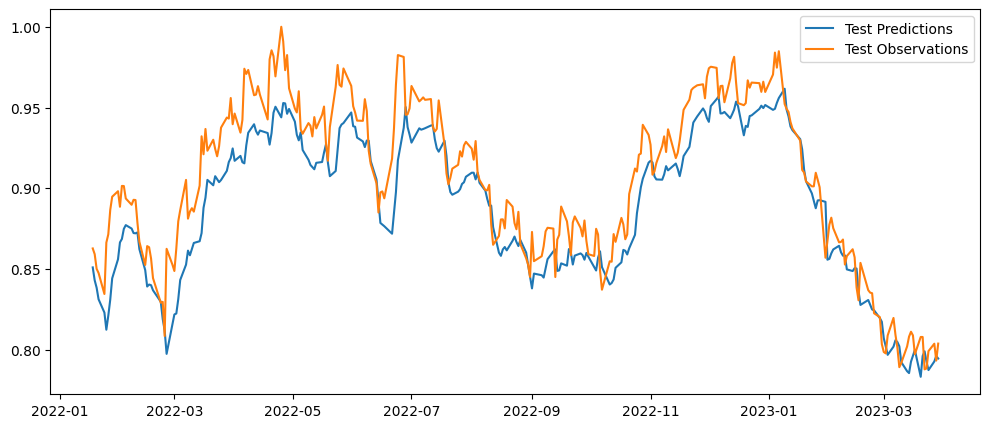

JNJ: Completed 16/20 iterations
HD


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 7ms/step - loss: 0.0019 - mae: 0.0231 - val_loss: 4.2605e-04 - val_mae: 0.0156
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 6.4417e-05 - mae: 0.0052 - val_loss: 2.7368e-04 - val_mae: 0.0125
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 5.7566e-05 - mae: 0.0050 - val_loss: 2.6577e-04 - val_mae: 0.0127
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 6.8703e-05 - mae: 0.0055 - val_loss: 4.1464e-04 - val_mae: 0.0168
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 6.7717e-05 - mae: 0.0056 - val_loss: 3.7622e-04 - val_mae: 0.0158
Epoch 6/30
79/79 [==============================] - 0s 4ms/step - loss: 6.2562e-05 - mae: 0.0053 - val_loss: 4.6063e-04 - val_mae: 0.0167
Epoch 7/30
79/79 [==============================] - 0s 4ms/step - loss: 7.9434e-05 - mae: 0.0063 - val_loss: 3.8511e-04 - val_mae: 0.0151
Epoch 8/30
79/79 [==============================]

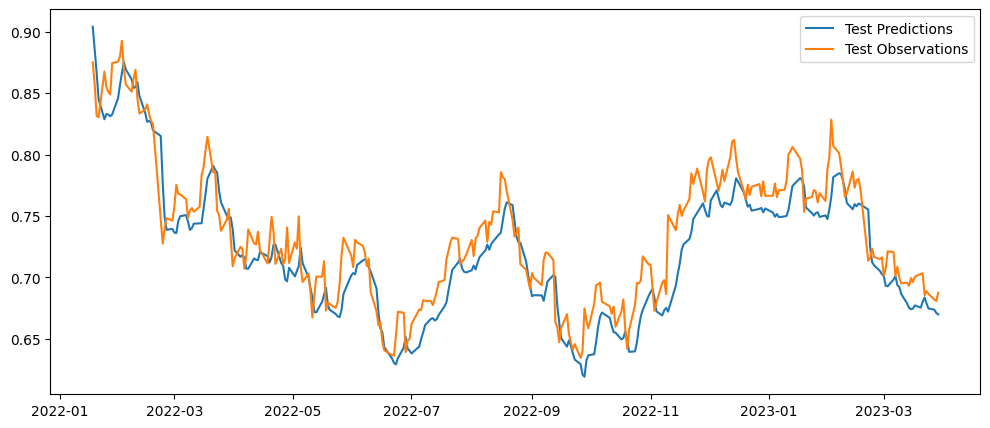

HD: Completed 17/20 iterations
MA


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0036 - mae: 0.0305 - val_loss: 6.0039e-04 - val_mae: 0.0189
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1564e-04 - mae: 0.0061 - val_loss: 7.1222e-04 - val_mae: 0.0209
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1418e-04 - mae: 0.0065 - val_loss: 5.8876e-04 - val_mae: 0.0185
Epoch 4/30
79/79 [==============================] - 0s 4ms/step - loss: 1.3065e-04 - mae: 0.0073 - val_loss: 0.0011 - val_mae: 0.0280
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1628e-04 - mae: 0.0068 - val_loss: 6.6296e-04 - val_mae: 0.0199
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1943e-04 - mae: 0.0072 - val_loss: 0.0010 - val_mae: 0.0264
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 1.2493e-04 - mae: 0.0073 - val_loss: 9.2477e-04 - val_mae: 0.0249
Epoch 8/30
79/79 [==============================] - 0s 3m

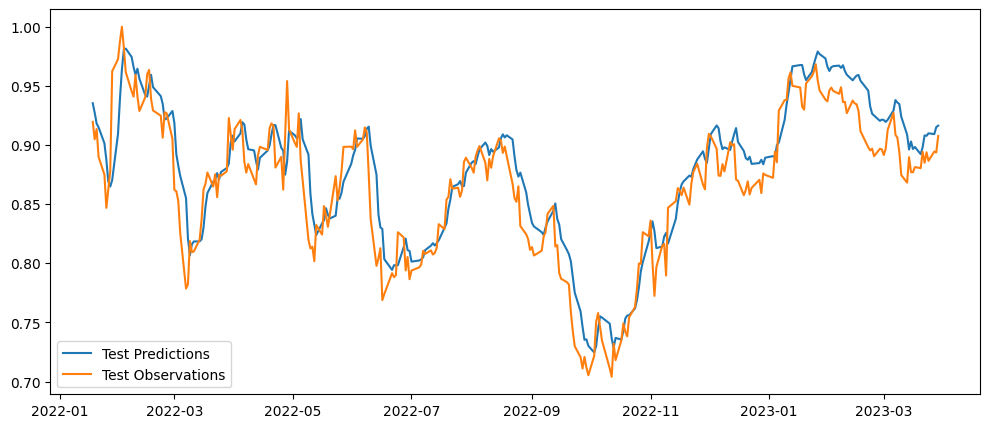

MA: Completed 18/20 iterations
PG


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 6ms/step - loss: 0.0033 - mae: 0.0293 - val_loss: 3.1152e-04 - val_mae: 0.0143
Epoch 2/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1140e-04 - mae: 0.0070 - val_loss: 4.2672e-04 - val_mae: 0.0174
Epoch 3/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1087e-04 - mae: 0.0071 - val_loss: 2.0764e-04 - val_mae: 0.0116
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1347e-04 - mae: 0.0073 - val_loss: 3.2030e-04 - val_mae: 0.0147
Epoch 5/30
79/79 [==============================] - 0s 3ms/step - loss: 1.1083e-04 - mae: 0.0073 - val_loss: 2.0162e-04 - val_mae: 0.0113
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 1.0020e-04 - mae: 0.0067 - val_loss: 3.1973e-04 - val_mae: 0.0148
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 1.3913e-04 - mae: 0.0082 - val_loss: 2.0774e-04 - val_mae: 0.0114
Epoch 8/30
79/79 [==============================]

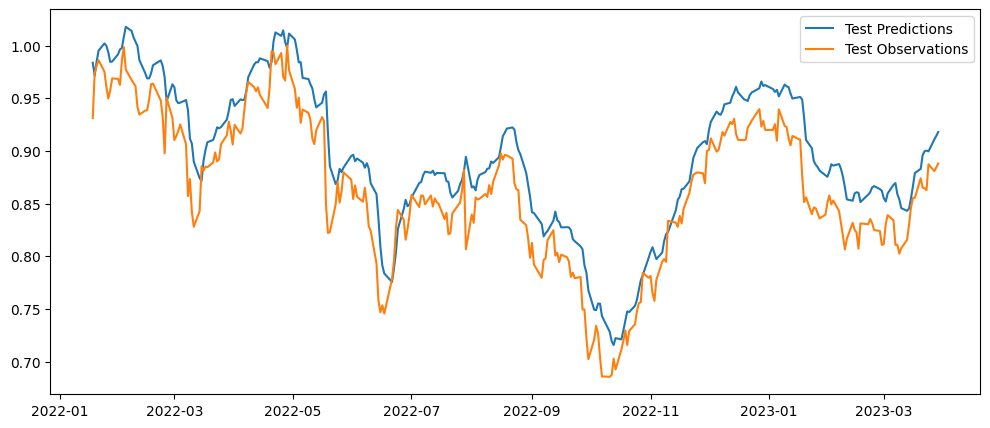

PG: Completed 19/20 iterations
MRK


[*********************100%%**********************]  1 of 1 completed

Epoch 1/30


79/79 [==============================] - 2s 7ms/step - loss: 0.0029 - mae: 0.0281 - val_loss: 3.2842e-04 - val_mae: 0.0132
Epoch 2/30
79/79 [==============================] - 0s 4ms/step - loss: 8.9855e-05 - mae: 0.0066 - val_loss: 4.9446e-04 - val_mae: 0.0180
Epoch 3/30
79/79 [==============================] - 0s 4ms/step - loss: 9.1957e-05 - mae: 0.0069 - val_loss: 2.8749e-04 - val_mae: 0.0125
Epoch 4/30
79/79 [==============================] - 0s 3ms/step - loss: 1.0553e-04 - mae: 0.0075 - val_loss: 2.7443e-04 - val_mae: 0.0120
Epoch 5/30
79/79 [==============================] - 0s 4ms/step - loss: 9.6068e-05 - mae: 0.0070 - val_loss: 2.7386e-04 - val_mae: 0.0120
Epoch 6/30
79/79 [==============================] - 0s 3ms/step - loss: 8.9975e-05 - mae: 0.0068 - val_loss: 2.5897e-04 - val_mae: 0.0114
Epoch 7/30
79/79 [==============================] - 0s 3ms/step - loss: 8.9749e-05 - mae: 0.0068 - val_loss: 3.9995e-04 - val_mae: 0.0159
Epoch 8/30
79/79 [==============================]

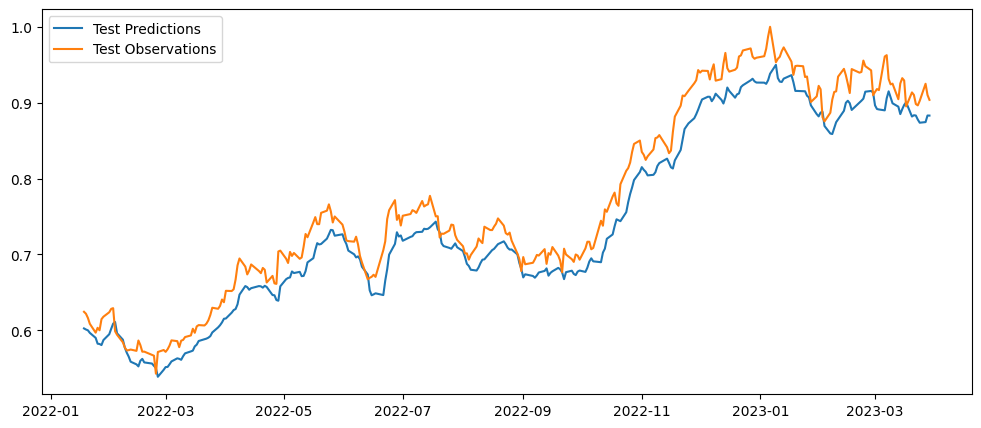

MRK: Completed 20/20 iterations


In [8]:
pred_dict = {}
i = 0
ticker_list = ticker_weights.iloc[:num_stocks]
while i < len(ticker_list):
    ticker = ticker_list.iloc[i]['Symbol']
    print(ticker)
    pred_dict[ticker] = get_lstm_pred([ticker], macro, start_date, end_date, train_prop, val_prop, look_back, epochs)
    i += 1
    print(f'{ticker}: Completed {i}/{len(ticker_list)} iterations')

##### Cumulative Weighted Returns DataFrame 

In [9]:
ticker_list = ticker_list.set_index(['Symbol'])
ticker_list['Adj Weight']= ticker_list['Weight']/sum(ticker_list['Weight'])
w_long_ret_df = pd.DataFrame()
w_strat_ret_df = pd.DataFrame()

for i, ticker in enumerate(ticker_list.index):
    w_long_ret_df[f'{i+1}. {ticker} Long WCR'] = pred_dict[ticker]['Long Cum Ret']*ticker_list.loc[ticker]['Adj Weight']
    w_strat_ret_df[f'{i+1}. {ticker} Strat WCR'] = pred_dict[ticker]['Strat Cum Ret']*ticker_list.loc[ticker]['Adj Weight']
# WCR := 'Weighted Cumulative Return'

##### Combintion of Returns into one DataFramne

In [10]:
port_ret = pd.DataFrame() # ETF is a weighted blend of the selected stocks from the S&P 500
port_ret['Long Returns'] = w_long_ret_df.sum(axis=1)
port_ret['Strat Returns'] = w_strat_ret_df.sum(axis=1)

display(port_ret)

,Long Returns,Strat Returns
2022-01-18,0.000000,0.000000
2022-01-19,-0.011571,-0.010258
2022-01-20,-0.023830,-0.020165
2022-01-21,-0.045909,-0.038032
2022-01-24,-0.046399,-0.038589
...,...,...
2023-03-23,-0.067609,0.024399
2023-03-24,-0.064978,0.024145
2023-03-27,-0.070117,0.025006
2023-03-28,-0.074650,0.024863


In [25]:
# Volatility
port_vol = np.std(port_ret['Strat Returns']) * np.sqrt(252)
long_vol = np.std(port_ret['Long Returns']) * np.sqrt(252)
print('Strat Volatility: {:.2f}%'.format(port_vol * 100))
print('Long Volatility: {:.2f}%'.format(long_vol * 100))

# Calculate Daily Risk-Free Rate from APY
r_f = (1 + macro['3 Mo Yield'] / 100)**(1/252) - 1

# Sharpe Ratios
port_sharpe = np.mean(port_ret['Strat Returns'] - r_f) / port_vol
long_sharpe = np.mean(port_ret['Long Returns'] - r_f) / long_vol
print('Strategy Sharpe Ratio: {:.2f}'.format(port_sharpe))
print('Long Sharpe Ratio: {:.2f}'.format(long_sharpe))


Strat Volatility: 43.01%
Long Volatility: 108.29%
Strategy Sharpe Ratio: -0.02
Long Sharpe Ratio: -0.10


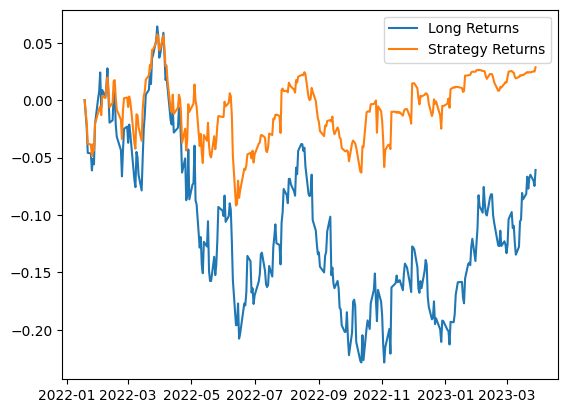

In [11]:
plt.plot(port_ret.index, port_ret['Long Returns'])
plt.plot(port_ret.index, port_ret['Strat Returns'])
plt.legend(['Long Returns','Strategy Returns'])
plt.show()